<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Eligible-population-stats" data-toc-modified-id="Eligible-population-stats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Eligible population stats</a></span></li></ul></div>

This notebook is from Fall 2022. 
It uses the court data we scraped in October 2021 to model cannabis policy in VA. Note that this is so old I had to change a couple things to get it to work again, so probably worth cross referencing against other more recent policies that use the same dataset and it might warrant some preprocessing updates.

In [31]:
import os
import sys
sys.path.insert(0, os.path.relpath('../')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

sys.path.append("C:\\Users\\annvu\\OneDrive\\Desktop\\GitHub\\stanford-decarceration-collective-ds\\stanford-decarceration-collective-ds\\modules")

from super_simulation.super_simulation_factory import SuperSimulationFactory
from transition_table import TransitionTable
from shell_compartment import ShellCompartment
from spark_policy import SparkPolicy
from utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data cleaning
Tip: you'll probably want to save the preprocessed file to a csv the first time you run this for a new policy and then import that csv from then on out to save time. To do so, uncomment the `df.to_csv()` line at the bottom of
this section, then after you run it move that file to `recidiviz-staging>recidiviz>calculator>modeling>population_projection>state>VA>VA_data`. From then on, you can skip everything in the data cleaning section and just run the file import commented out at the end of the section.

In [32]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [33]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../../state_data/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv', # ../ is to back a folder
        index_col=0
    ) for i in range(8)
])

C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1842010540.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1842010540.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1842010540.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1842010540.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1842010540.py:2: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(
C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1842010540.py:2: DtypeWarning

In [34]:
# This is to make it easier to label data based on violation codes
codes = sdc_data['CodeSection'].unique().astype(str)
charges = sdc_data['Charge'].unique().astype(str)

def containing(a, substr):
    b = []
    for el in a:
        if substr.lower() in el.lower():
            b.append(el)
    return b

containing(codes, "18.2-374.1")

[np.str_('18.2-374.1'),
 np.str_('18.2-374.1 B1)'),
 np.str_('18.2-374.1B2'),
 np.str_('18.2-374.1-B(2)'),
 np.str_('B.18.2-374.1'),
 np.str_('18.2-374.1(B)'),
 np.str_('18.2-374.1(B[.]2)'),
 np.str_('18.2-374.1(B)(3'),
 np.str_('18.2-374.1B3'),
 np.str_('18.2-374.1(B)4'),
 np.str_('18.2-374.1(B[.]3)'),
 np.str_('18.2-374.1(B)(4'),
 np.str_('18.2-374.1B1&.2'),
 np.str_('18.2-374.1B(1)'),
 np.str_('18.2-374.1B(2)'),
 np.str_('18.2-374.1 B(1)'),
 np.str_('18.2-374.1(B)2'),
 np.str_('18.2-374.1A'),
 np.str_('18.2-374.1B4'),
 np.str_('18.2-374.1(B[.]1)'),
 np.str_('18.2-374.1C2'),
 np.str_('18.2-374.1 B. 2'),
 np.str_('18.2-374.1(B)(2'),
 np.str_('18.2-374.1(B)(1'),
 np.str_('18.2-374.1(B2)'),
 np.str_('18.2-374.1.1'),
 np.str_('18.2-374.1(C)'),
 np.str_('C.18.2-374.1'),
 np.str_('A.18.2-374.1'),
 np.str_('18.2-374.1 B.1')]

In [35]:
'''
Modeling Assumptions made here:
 - Child-adult distinctions are not made unless under separate codes. Codes are treated under highest severity (ex. in alternative A, 18.2-67.1 committed against an adult is treated as 18.2-67.1 committed against a child)
 - All offenses are assumed repeat where those rules apply (ex. in alternative A, 18.2.30 is always in the 30-year tier)
 - Subsection-level distinctions are not made. If a tier includes some subsection of a code, the whole code is included
 - Inchoate offenses are not factored in
'''
# Note: We can't see repeat offenses in the data as-is, so all rules applying to repeat offenses will be applied to all offense of that type
## This means our model of the policy will generally let people out later, so our estimates will be more conservative
# This also does not include any of the inchoate conviction clauses
# 

policy_scenarios = {
    'original': [
        [],
        [],
        ['F1', '18.2-31', '18.2-30', '18.2-40', '18.2-45', '18.2-46.5', '18.2-46.6', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-274.1', '18.2-355', '18.2-371.1', '18.2-481'],
        ['18.2-32', '18.2-41', '18.2-51', '18.2-51.1', '18.2-51.2', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2.90', '18.2-77', '18.2-79', '18.2-80', '18.2-79', '18.2-80', '18.2-79', '18.2-374.1C', '18.2-374.1(C)'],
        ['F*']
    ],
    'a': [
        [],
        ['F1', '18.2.31', '18.2.30'],
        ['18.2-40', '18.2-45', '18.2-46.5', '18.2-46.6', '18.2-46.6', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-64.2', '18.2-274.1', '18.2-274.1', '18.2-355', '18.2-371.1', '18.2-481'],
        ['18.2-32', '18.2-41', '18.2-51', '18.2-51.1', '18.2-51.2', '18.2-61', '18.2-90', '18.2-77', '18.2-79', '18.2-80', '18.2-374.1'],
        ['F*']
    ],
    'b': [
        ['18.2-31', '18.2-30'],
        [],
        ['18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-46.6', '18.2-274.1', '18.2-40', '18.2-45', '18.2-481', '18.2-371.1'],
        [],
        ['F*']
    ],
    'c': [
        ['18.2.31', '18.2-30'],
        [],
        ['18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-46.6', '18.2-274.1', '18.2-40', '18.2-45', '18.2-481', '18.2-371.1'],
        ['18.2-32', '18.2-61', '18.2-67.1', '18.2-67.2', '18.2-67.3', '18.2-63', '18.2-64.1', '18.2-64.2', '18.2-51', '18.2-77', '18.2-79', '18.2-80', '18.2-41', '18.2-51', '18.2-51.1', '18.2-79', '18.2-374.1'],
        ['F*']
    ],
    'no_carveouts':[

    ]
}

# Here you can change the version of the bill we're using
scenario = 'original'

In [36]:
sdc_data['Charge Type'].unique()

array(['Misdemeanor', 'M', 'F', 'Felony', 'Infraction', 'Civil', nan,
       'Other (Animal Violations[.] Bond Appeals)', 'I'], dtype=object)

In [37]:
# Add tier column
sdc_data["tier"] = np.nan

In [38]:
sdc_data['Charge Type'].unique()

array(['Misdemeanor', 'M', 'F', 'Felony', 'Infraction', 'Civil', nan,
       'Other (Animal Violations[.] Bond Appeals)', 'I'], dtype=object)

In [39]:
# Assign tiers for a given policy scenario
for tier, tier_codes in enumerate(policy_scenarios[scenario]):
    for code in tier_codes:
        conditions = None
        # Class-1 felonies
        if code == 'F1':
            conditions = (sdc_data['Class'] == '1') & (sdc_data['Charge Type'].isin(['F', 'Felony']))
        # All other felonies
        if code == 'F*':
            conditions = sdc_data['Charge Type'].isin(['F', 'Felony'])
        # Actual codes
        else:
            # This is for catching minor abberations in how codes are written out
            possible_codes = containing(codes, code) + containing(codes, code.replace('-','.'))
            conditions = sdc_data['CodeSection'].isin(possible_codes)   

        sdc_data.loc[conditions & sdc_data['tier'].isna(), 'tier'] = tier

In [40]:
sdc_data.loc[sdc_data['tier'].isna(), 'tier'] = 0 

In [41]:
sdc_data[sdc_data['Charge'] == 'MURDER']['CodeSection']

490        Z.18.2-32
1092       A.18.2-32
1706         18.2-32
1876       A.18.2-32
2872         18.2-32
             ...    
1069348      18.2-32
1069663      18.2-32
1070613      18.2-33
1070928      18.2-33
1071511      18.2-32
Name: CodeSection, Length: 2106, dtype: object

# Attempt w/o Spark

In [42]:
# Create cleaner, more usable data set

# Calclate the total population in 2022 based on the data. Use that to figure out what we need to scale up by to get the 2025. numbers.
# Make the data look like the 2025 numbers. Calculate based off of that. Figure out a ratio to find the 2025.

# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching
scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
"""pop_scale_factor = current_total_population/len(sdc_data['pesron_id']) # COULD BE MULTIPLE CRIMES FOR THE SAME PERSON. """
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column. Timestep in which they are incarcerated
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month

# get relevant info. don't need DOB, but can add later if we want to do that analysis
sorted_data = sorted_data[['time_step', 'tier', 'LOS']].copy()
sorted_data['compartment_duration'] = sorted_data['LOS'].round()
sorted_data = sorted_data.drop('LOS', axis=1)
sorted_data['weight'] = scale_factor  # scale weights to handle missing data [MAYBE CHECK]
    #### For if 50% of the entries are null. Accounts for the fact that we're missing 50% of inmates.    

# keep only people admitted before 33 [MAYBE CHECK]
sorted_data = sorted_data[(sorted_data['time_step'] <= 33)]  # IS IT OK TO GET RID OF -108 CONDITION? WAS "sorted_data['time_step'] > -108)&"

sorted_data.time_step = sorted_data.time_step.astype(int)

C:\Users\annvu\AppData\Local\Temp\ipykernel_27644\1713898976.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


In [43]:
len(np.unique(sdc_data[sdc_data['sentence_time']!='0']['DOB'].unique()))

366

In [44]:
sorted_data.head()

,time_step,tier,compartment_duration,weight
14,30,4.0,4.0,1.665042
22,-177,4.0,39.0,1.665042
32,-81,2.0,194.0,1.665042
41,-217,4.0,11.0,1.665042
42,-47,4.0,8.0,1.665042


(0.0, 20.0)

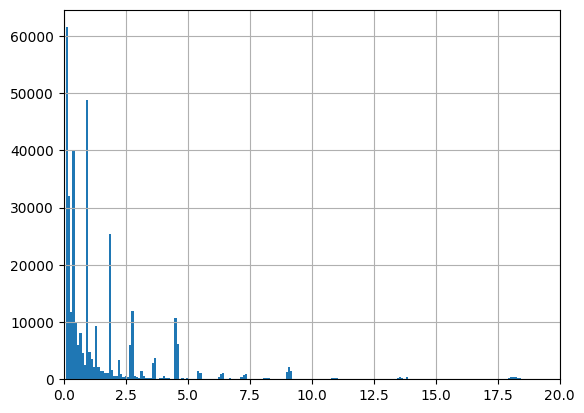

In [45]:
(no_policy_data['compartment_duration']/12).hist(bins=1000)
plt.xlim([0,20])

In [46]:
# Calculate people released at each time step WITHOUT policy. Note we don't care about incoming people -- none are affected
START_STEP = 84 # start of 2026 fiscal year

no_policy_data = sorted_data.copy()

no_policy_data['release_month'] = no_policy_data['time_step'] + no_policy_data['compartment_duration']  # month of release
no_policy_data['release_year'] = (no_policy_data['release_month'] - START_STEP) // 12  # years between policy start (48) and released
no_policy_nums_released = no_policy_data.groupby(['release_year'], as_index=False).sum()

# get number released years 0 though 4
no_policy_yearly_releases = np.array([no_policy_nums_released.loc[no_policy_nums_released['release_year'] == i, 'weight'].values[0] for i in range(5)])
no_policy_total_releases = no_policy_yearly_releases.copy()
for i in range(1, 5):  # get cumulative releases at each time step
    no_policy_total_releases[i] = no_policy_total_releases[i] + no_policy_total_releases[i - 1]

print(no_policy_yearly_releases)
print(no_policy_total_releases)

[1235.46149735  835.85130953  752.59918706  551.1290507   497.84769233]
[1235.46149735 2071.31280687 2823.91199393 3375.04104464 3872.88873696]


In [47]:
def make_cumulative(array):
    new_array = array.copy()
    for i in range(1, len(new_array)):
        new_array[i] = new_array[i] + new_array[i - 1]
    return new_array

In [48]:
import pandas as pd

df = pd.DataFrame({'a': [1]})
df2 = df[df['a'] == 1]
df2['a'] *= 2

df

,a
0,1


In [49]:
# Calculate people released at each time step WITH policy. Note we don't care about incoming people -- none are affected

# This estimates resentencing frequency/outcomes using the parole set-off system used in Texas
# originally found in https://www.secondlooktexas.org/action
GRANT_RATE = 3 / (32 + 3)  

# We don't have data on the distribution of set-off times after each hearing, so doing every other year
SETOFF_TIME = 24

# Months of sentence that must be served to be eligible for Second Look. Tier 0 never eligible
TIER_SENTENCE_LENGTHS = np.array([999999, 30 * 12, 25 * 12, 20 * 12, 15 * 12])


policy_data = sorted_data.copy()

policy_data['release_month'] = policy_data['time_step'] + policy_data['compartment_duration']  # month of release
policy_data['tier_sentence_lengths'] = TIER_SENTENCE_LENGTHS[policy_data['tier'].astype('int64')]  # time when eligible for policy
policy_data['next_chance_to_apply'] = policy_data['time_step'] + policy_data['tier_sentence_lengths']  # next chance to apply (eg after rejection)


additional_releases = np.zeros(5)
policy_yearly_releases = np.zeros(5)
life_years_timed = np.zeros(5)  # life years saved, at time of reference (eg if 3 years early, 1 first year, 2 second, 3 third)
life_years_immediate = np.zeros(5)  # life years saved, applied immediately (eg if 3 years early, 3 first year, 3 second, 3 third)

for year in range(5):
    time = START_STEP + 12 * year  # start month, plus months of years so far, shifted to start in July 2024
    # Select people who can apply before end of year but not set to be released yet [MAYBE CHECK]
    filter = (time + 11 >= policy_data['next_chance_to_apply']) & (time + 11 < policy_data['release_month'])
    eligible_data = policy_data.loc[filter]
    print("Number of eligible applicants in the " + str(year) + " year after passing:", eligible_data['weight'].sum())  # Number of people eligible to apply each year
    additional_releases[year] += GRANT_RATE * eligible_data['weight'].sum()  # release GRANT_RATE proportion of eligible people
    
    early_release_months = eligible_data['release_month'] - (time + 11)  #  in case released at end of year, underestimate for years [MAYBE CHECK]
    
    # find years saved over time [MAYBE CHECK]
    years_and_weights = pd.DataFrame([early_release_months // 12, eligible_data['weight']])  # df with only years saved and weights
    years_and_weights = years_and_weights.rename({'release_month': 'years_saved'}).transpose()
    years_and_weights = years_and_weights.groupby(['years_saved'], as_index=False).sum()  # sum weights for each year
    for i in range(year, 5):  # add a year saved for each person who would have been in prison in each year
        life_years_timed[i] += years_and_weights.loc[years_and_weights['years_saved'] > i, 'weight'].sum() * GRANT_RATE
    
    # add total time saved for each person released [MAYBE CHECK]
    for i in range(year, 5):
        life_years_immediate[i] += GRANT_RATE * (eligible_data['weight'] * early_release_months).sum() / 12
    
    policy_data.loc[filter, 'weight'] *= 1 - GRANT_RATE  # take released people out of set
    policy_data.loc[filter, 'next_chance_to_apply'] = time + SETOFF_TIME 

    # release people set to be released normally by end of year [MAYBE CHECK]
    policy_yearly_releases[year] = policy_data.loc[(time + 11 >= policy_data['release_month'])
            & (time - 1 < policy_data['release_month']), 'weight'].sum() + additional_releases[year]


policy_total_releases = make_cumulative(policy_yearly_releases)
additional_releases_cumulative = make_cumulative(additional_releases)
life_years_timed_cumulative = make_cumulative(life_years_timed)
life_years_immediate_cumulative = make_cumulative(life_years_immediate)

print("Additional releases each year:", additional_releases)
print("Additional releases, cumulative:", additional_releases_cumulative)
print("Yearly releases:", policy_yearly_releases)
print("Total releases:", policy_total_releases)
print("Life years, timed: ", life_years_timed) # life years saved, at time of reference (eg if 3 years early, 1 first year, 2 second, 3 third)
print("Life years, immediate:", life_years_immediate) # life years saved, applied immediately (eg if 3 years early, 3 first year, 3 second, 3 third)
print("Life years, timed, cumulative: ", life_years_timed_cumulative) # life years saved, at time of reference (eg if 3 years early, 1 first year, 2 second, 3 third)
print("Life years, immediate, cumulative: ", life_years_immediate_cumulative) # life years saved, applied immediately (eg if 3 years early, 3 first year, 3 second, 3 third)

df = pd.DataFrame()

df['Years after policy passed'] = np.array([1,2,3,4,5])
df['People released (per year)'] = additional_releases
df['People released (cumulative)'] = additional_releases_cumulative
df['Life years saved (real-time, per year)'] = life_years_timed
df['Life years saved (real-time, cumulative)'] = life_years_timed_cumulative
df['Life years saved (all-at-once, per year)'] = life_years_immediate
df['Life years saved (all-at-once, cumulative)'] = life_years_immediate_cumulative

Number of eligible applicants in the 0 year after passing: 1695.013213340129
Number of eligible applicants in the 1 year after passing: 174.82945717162428
Number of eligible applicants in the 2 year after passing: 1477.9392505988712
Number of eligible applicants in the 3 year after passing: 306.4153833040631
Number of eligible applicants in the 4 year after passing: 1314.3777133491342
Additional releases each year: [145.28684686  14.98538204 126.68050719  26.26417571 112.66094686]
Additional releases, cumulative: [145.28684686 160.2722289  286.9527361  313.21691181 425.87785867]
Yearly releases: [1380.7483442   839.13382178  867.43410655  559.01523543  588.8155147 ]
Total releases: [1380.7483442  2219.88216599 3087.31627253 3646.33150796 4235.14702267]
Life years, timed:  [134.86843839 136.58105348 227.9735345  226.87664531 291.16180807]
Life years, immediate: [2305.03719411 2532.88636013 4626.03738803 4957.5932133  6817.02712579]
Life years, timed, cumulative:  [ 134.86843839  271.449

In [52]:
# find costs avoided by releasing people # or, marginal cost!s
COST_PER_YEAR = 20130.19  # seen in https://vadoc.virginia.gov/media/1813/vadoc-financial-annual-mis-report-2022.pdf

# find valued for timed years
cost_avoided_timed_yearly = life_years_timed.copy() * COST_PER_YEAR
cost_avoided_timed_cumulative = make_cumulative(cost_avoided_timed_yearly)

# find valued for immediate years
cost_avoided_immediate_yearly = life_years_immediate.copy() * COST_PER_YEAR
cost_avoided_immediate_cumulative = make_cumulative(cost_avoided_immediate_yearly)

print("Cost avoided each year, timed:", cost_avoided_timed_yearly)
print("Cumulative cost avoided, timed:", cost_avoided_timed_cumulative)
print("Cost avoided each year, immediate:", cost_avoided_immediate_yearly)
print("Cumulative cost avoided, immediate:", cost_avoided_immediate_cumulative)

df['Cost avoided (real-time, per year)'] = cost_avoided_timed_yearly
df['Cost avoided (real-time, cumulative)'] = cost_avoided_timed_cumulative
df['Cost avoided (immediate, per year)'] = cost_avoided_immediate_yearly
df['Cost avoided (immediate, cumulative)'] = cost_avoided_immediate_cumulative

Cost avoided each year, timed: [2714927.28978471 2749402.55695658 4589150.56439255 4567069.97660866
 5861142.51714577]
Cumulative cost avoided, timed: [ 2714927.28978471  5464329.84674129 10053480.41113383 14620550.38774249
 20481692.90488826]
Cost avoided each year, immediate: [4.64008367e+07 5.09874837e+07 9.31230116e+07 9.97972933e+07
 1.37228051e+08]
Cumulative cost avoided, immediate: [4.64008367e+07 9.73883204e+07 1.90511332e+08 2.90308625e+08
 4.27536677e+08]


In [53]:
# find labor boost by releasing people
YEARLY_LABOR_BOOST = 18220.8 * 12.77/ 11  # 18220 calculated a year ago, and wage has since increased from 11 to 12.77
UNEMPLOYMENT_RATE = 0.27  # found here, nationwide stathttps://www.prisonpolicy.org/reports/outofwork.html


# find valued for timed years
labor_timed_yearly = life_years_timed.copy() * YEARLY_LABOR_BOOST * (1 - UNEMPLOYMENT_RATE)
labor_timed_cumulative = make_cumulative(labor_timed_yearly)

# find valued for immediate years
labor_immediate_yearly = life_years_immediate.copy() * YEARLY_LABOR_BOOST * (1 - UNEMPLOYMENT_RATE)
labor_immediate_cumulative = make_cumulative(labor_immediate_yearly)

print("Labor boost each year, timed:", labor_timed_yearly)
print("Cumulative labor boost, timed:", labor_timed_cumulative)
print("Labor boost each year, immediate:", labor_immediate_yearly)
print("Cumulative labor boost, immediate:", labor_immediate_cumulative)

df['Labor boost (real-time, per year)'] = labor_timed_yearly
df['Labor boost (real-time, cumulative)'] = labor_timed_cumulative
df['Labor boost (immediate, per year)'] = labor_immediate_yearly
df['Labor boost (immediate, cumulative)'] = labor_immediate_cumulative

Labor boost each year, timed: [2082566.32837711 2109011.61508666 3520245.45085132 3503307.87436354
 4495964.99248979]
Cumulative labor boost, timed: [ 2082566.32837711  4191577.94346377  7711823.39431509 11215131.26867862
 15711096.26116841]
Labor boost each year, immediate: [3.55931521e+07 3.91114772e+07 7.14327964e+07 7.65525042e+07
 1.05264889e+08]
Cumulative labor boost, immediate: [3.55931521e+07 7.47046293e+07 1.46137426e+08 2.22689930e+08
 3.27954819e+08]


In [54]:
df.to_csv('aclu-original_2026.csv')